Import required libraries

In [1]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import random
import glob
import os

# Set the random seed for TensorFlow, numpy and Python to make the results reproducible
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)

# Set the option to display all columns
pd.set_option('display.max_columns', None)

# Set the option to display all rows
pd.set_option('display.max_rows', None)

Load our datasets

In [2]:
# Get our file path for the .csv files
file_paths = [f for f in os.listdir("./Dataset/") if f.endswith('.csv')]

# Define list for our data frames
li = []

# Loop through our file paths and read the .csv files into a data frame
for filename in file_paths:
    filename = "./Dataset/" + filename
    
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

# Concatenate our data frames into one central data frame
match_df = pd.concat(li, axis=0, ignore_index=True)

# Have a look at our data frame
match_df.head()


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,Time,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,11/08/2017,Arsenal,Leicester,4,3,H,2,2,D,M Dean,27,6,10,3,9,12,9,4,0,1,0,0,1.53,4.5,6.50,1.50,4.60,6.75,1.47,4.5,6.50,1.44,4.40,6.50,1.53,4.55,6.85,1.53,4.2,6.00,1.53,4.50,6.50,41.0,1.55,1.51,4.60,4.43,6.89,6.44,37.0,1.65,1.61,2.43,2.32,21.0,-1.00,1.91,1.85,2.10,2.02,1.49,4.73,7.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,12/08/2017,Brighton,Man City,0,2,A,0,0,D,M Oliver,6,14,2,4,6,9,3,10,0,2,0,0,11.00,5.5,1.33,11.00,5.25,1.30,8.00,5.3,1.35,10.00,5.00,1.30,10.95,5.55,1.34,10.00,4.8,1.33,10.00,5.50,1.33,40.0,11.50,10.10,5.60,5.25,1.36,1.32,35.0,1.70,1.63,2.40,2.27,20.0,1.50,1.95,1.91,2.01,1.96,11.75,6.15,1.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,12/08/2017,Chelsea,Burnley,2,3,A,0,3,A,C Pawson,19,10,6,5,16,11,8,5,3,3,2,0,1.25,6.5,15.00,1.22,6.50,12.50,1.22,6.2,13.50,1.25,5.75,15.00,1.26,6.30,15.25,1.25,5.5,13.00,1.25,6.25,15.00,41.0,1.27,1.24,6.55,6.06,15.50,13.67,36.0,1.71,1.66,2.33,2.23,20.0,-1.75,2.03,1.97,1.95,1.90,1.33,5.40,12.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,12/08/2017,Crystal Palace,Huddersfield,0,3,A,0,2,A,J Moss,14,8,4,6,7,19,12,9,1,3,0,0,1.83,3.6,5.00,1.80,3.50,4.75,1.85,3.5,4.30,1.80,3.40,4.60,1.83,3.58,5.11,1.80,3.3,5.00,1.83,3.60,5.00,41.0,1.86,1.81,3.65,3.50,5.11,4.82,36.0,2.19,2.11,1.79,1.72,18.0,-0.75,2.10,2.05,1.86,1.83,1.79,3.56,5.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,12/08/2017,Everton,Stoke,1,0,H,1,0,H,N Swarbrick,9,9,4,1,13,10,6,7,1,1,0,0,1.70,3.8,5.75,1.70,3.60,5.50,1.70,3.7,5.00,1.67,3.60,5.25,1.70,3.83,5.81,1.70,3.5,5.50,1.70,3.80,5.75,40.0,1.71,1.69,3.85,3.69,6.00,5.50,35.0,2.17,2.08,1.80,1.76,19.0,-0.75,1.94,1.90,2.01,1.98,1.82,3.49,5.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Get our team overall ratings by season
team_overall_ratings_df = pd.read_csv("./Dataset/seasonal_ratings/seasonal_team_rating.csv", index_col=None, header=0)

# Have a look at our data frame
team_overall_ratings_df.head()

,Season,Team,Rating
0,2022-2023,Man City,85
1,2022-2023,Liverpool,84
2,2022-2023,Arsenal,82
3,2022-2023,Chelsea,82
4,2022-2023,Man United,82


Re-format dataset structure / namings etc. and join both datasets together

In [4]:
# Drop the "Div" column as this is just indicates what football division the data is for
# not relevant for our analysis as we already know it is looking at the Premier League
match_df = match_df.drop(["Div"], axis=1)

In [5]:
# Add season column to see what season the match was played in

# Convert Date column from object to datetime
match_df["Date"] = pd.to_datetime(match_df["Date"], format='%d/%m/%Y')

# Define the date ranges for each season from 2017/18 to 2022/23
seasons = {
    '2017-2018': ('2017-08-11', '2018-05-13'),
    '2018-2019': ('2018-08-10', '2019-05-12'),
    '2019-2020': ('2019-08-09', '2020-07-26'),
    '2020-2021': ('2020-09-12', '2021-05-23'),
    '2021-2022': ('2021-08-13', '2022-05-22'),
    '2022-2023': ('2022-08-05', '2023-05-28')
}

# Define a function to get the season given a date
def get_season(date):
    
    for season, (start_date, end_date) in seasons.items():
        if pd.to_datetime(start_date) <= date <= pd.to_datetime(end_date):
            return season
        
    return 'Unknown'  # Or whatever you want to return when the date doesn't fall into any of the defined seasons

# Create our new season column
match_df["Season"] = match_df["Date"].apply(get_season)

In [6]:
# Check the seasons have been added correctly by checking each season has the same number of matches (380)
match_df["Season"].value_counts()

Season
2017-2018    380
2018-2019    380
2019-2020    380
2020-2021    380
2021-2022    380
2022-2023    380
Name: count, dtype: int64

In [7]:
# Add the away and home team overall ratings to the match data frame

# Merge to get the home team ratings
match_df = pd.merge(match_df, team_overall_ratings_df, how='left', left_on=['Season', 'HomeTeam'], right_on=['Season', 'Team'])
match_df = match_df.rename(columns={'Rating': 'home_rating_overall'})
match_df = match_df.drop('Team', axis=1)  # drop the extra 'team' column

# Merge to get the away team ratings
match_df = pd.merge(match_df, team_overall_ratings_df, how='left', left_on=['Season', 'AwayTeam'], right_on=['Season', 'Team'])
match_df = match_df.rename(columns={'Rating': 'away_rating_overall'})
match_df = match_df.drop('Team', axis=1)  # drop the extra 'team' column

match_df.shape

(2280, 129)

Look at some basic statistics of the dataset

In [8]:
# Returns the summary of the DataFrame
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280 entries, 0 to 2279
Columns: 129 entries, Date to away_rating_overall
dtypes: datetime64[ns](1), float64(103), int64(18), object(7)
memory usage: 2.2+ MB


In [9]:
# Returns the statistical summary for numerical columns
match_df.describe()

,Date,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,home_rating_overall,away_rating_overall
count,2280,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,380.000000,380.000000,380.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.00000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,2280.000000,2280.000000,2280.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1519.000000,1519.000000,1519.000000,1519.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1517.000000,1517.000000,1517.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1519.000000,1519.000000,1520.000000,1520.00000,1520.00000,1520.000000,1520.000000,1519.000000,1519.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,2280.000000,2280.000000
mean,2020-07-10 08:19:34.736841984,1.519298,1.245175,0.682018,0.566228,13.610526,11.302193,4.682456,3.968421,10.455263,10.568421,5.670175,4.659211,1.556579,1.687281,0.049561,0.059211,3.052075,4.304031,4.864031,2.994561,4.226263,4.736732,2.956333,4.160943,4.566482,3.030105,4.139842,5.392316,3.106259,4.366351,5.037939,3.035689,4.142768,4.886934,3.100750,4.232232,5.063259,37.078947,3.363079,3.111368,4.656342,4.340934,6.078395,5.327750,34.205263,1.94475,1.871184,2.178934,2.079079,20.043421,-0.331250,2.013974,1.954829,1.994382,1.937684,3.143627,4.385189,5.019693,3.191480,4.457243,5.079289,3.002138,4.213987,4.603191,1.834510,2.088282,1.872014,2.138828,1.906033,2.186862,1.835803,2.094461,-0.257401,1.954336,1.950934,1.968934,1.956224,1.995941,1.990336,1.941842,1.935737,2.968316,4.202388,4.435421,2.966980,4.172026,4.453276,2.967950,4.079631,4.337930,3.027730,4.092855,4.607868,3.064789,4.163711,4.670092,3.290789,4.508632,5.129500,3.029717,4.223974,4.567375,1.846941,2.089447,1.887465,2.143351,1.931882,2.23748,1.84775,2.101803,-0.242105,1.945425,1.959131,1.961428,1.968526,2.015868,2.029276,1.935329,1.947717,78.350000,78.350000
min,2017-08-11 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.060000,2.800000,1.120000,1.050000,2.900000,1.130000,1.070000,2.700000,1.120000,1.080000,2.900000,1.180000,1.070000,2.950000,1.130000,1.050000,2.900000,1.120000,1.050000,2.900000,1.130000,32.000000,1.080000,1.060000,3.060000,2.930000,1.160000,1.130000,25.000000,1.24000,1.220000,1.450000,1.400000,14.000000,-3.000000,1.550000,1.500000,1.440000,1.400000,1.040000,2.890000,1.090000,1.090000,3.100000,1.180000,1.070000,2.970000,1.150000,1.220000,1.440000,1.200000,1.470000,1.220000,1.510000,1.210000,1.470000,-3.000000,1.70

In [10]:
# This will print the number of null values in each column
print(match_df.isnull().sum())

Date                      0
HomeTeam                  0
AwayTeam                  0
FTHG                      0
FTAG                      0
FTR                       0
HTHG                      0
HTAG                      0
HTR                       0
Referee                   0
HS                        0
AS                        0
HST                       0
AST                       0
HF                        0
AF                        0
HC                        0
AC                        0
HY                        0
AY                        0
HR                        0
AR                        0
B365H                     0
B365D                     0
B365A                     0
BWH                       0
BWD                       0
BWA                       0
IWH                       0
IWD                       0
IWA                       0
LBH                    1900
LBD                    1900
LBA                    1900
PSH                       0
PSD                 

In [11]:
# This will return a DataFrame with rows that have at least one missing value
df_with_nulls = match_df[match_df.isnull().any(axis=1)]

# To see the DataFrame
df_with_nulls.head()

# After comparing the original datasets in excel, certain seasons are missing some columns of data, most the NaN values are for the match betting odds columns

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,Time,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Season,home_rating_overall,away_rating_overall
0,2017-08-11,Arsenal,Leicester,4,3,H,2,2,D,M Dean,27,6,10,3,9,12,9,4,0,1,0,0,1.53,4.5,6.50,1.50,4.60,6.75,1.47,4.5,6.50,1.44,4.40,6.50,1.53,4.55,6.85,1.53,4.2,6.00,1.53,4.50,6.50,41.0,1.55,1.51,4.60,4.43,6.89,6.44,37.0,1.65,1.61,2.43,2.32,21.0,-1.00,1.91,1.85,2.10,2.02,1.49,4.73,7.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-2018,82,78
1,2017-08-12,Brighton,Man City,0,2,A,0,0,D,M Oliver,6,14,2,4,6,9,3,10,0,2,0,0,11.00,5.5,1.33,11.00,5.25,1.30,8.00,5.3,1.35,10.00,5.00,1.30,10.95,5.55,1.34,10.00,4.8,1.33,10.00,5.50,1.33,40.0,11.50,10.10,5.60,5.25,1.36,1.32,35.0,1.70,1.63,2.40,2.27,20.0,1.50,1.95,1.91,2.01,1.96,11.75,6.15,1.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-2018,75,84
2,2017-08-12,Chelsea,Burnley,2,3,A,0,3,A,C Pawson,19,10,6,5,16,11,8,5,3,3,2,0,1.25,6.5,15.00,1.22,6.50,12.50,1.22,6.2,13.50,1.25,5.75,15.00,1.26,6.30,15.25,1.25,5.5,13.00,1.25,6.25,15.00,41.0,1.27,1.24,6.55,6.06,15.50,13.67,36.0,1.71,1.66,2.33,2.23,20.0,-1.75,2.03,1.97,1.95,1.90,1.33,5.40,12.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-2018,83,77
3,2017-08-12,Crystal Palace,Huddersfield,0,3,A,0,2,A,J Moss,14,8,4,6,7,19,12,9,1,3,0,0,1.83,3.6,5.00,1.80,3.50,4.75,1.85,3.5,4.30,1.80,3.40,4.60,1.83,3.58,5.11,1.80,3.3,5.00,1.83,3.60,5.00,41.0,1.86,1.81,3.65,3.50,5.11,4.82,36.0,2.19,2.11,1.79,1.72,18.0,-0.75,2.10,2.05,1.86,1.83,1.79,3.56,5.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-2018,76,74
4,2017-08-12,Everton,Stoke,1,0,H,1,0,H,N Swarbrick,9,9,4,1,13,10,6,7,1,1,0,0,1.70,3.8,5.75,1.70,3.60,5.50,1.70,3.7,5.00,1.67,3.60,5.25,1.70,3.83,5.81,1.70,3.5,5.50,1.70,3.80,5.75,40.0,1.71,1.69,3.85,3.69,6.00,5.50,35.0,2.17,2.08,1.80,1.76,19.0,-0.75,1.94,1.90,2.01,1.98,1.82,3.49,5.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-2018,79,76


In [12]:
# Perform feature selection to confirm the betting columns do not provide any useful information

# correlation matrix creation
# Get rid of non-numeric columns as they will not be included in the correlation matrix 
# https://datascience.stackexchange.com/questions/63037/correlation-matrix-for-non-numeric-features
match_corr = match_df.drop(["Date", "HomeTeam", "AwayTeam", "Season", "FTR", "HTR", "Referee", "Time"], axis=1)

corr = match_corr.corr()

corr_m = corr.abs()

# upper triangle selection
upper1 = corr_m.where(np.triu(np.ones(corr_m.shape),
k=1).astype(bool))

# For correlation greater than 0.90, Find index of feature columns
droping = [col for col in upper1.columns if any(upper1[col] > 0.90)]

print('Features to be dropped are: ', droping)

# We can now see all the betting odds columns are highly correlated with each other, contain a significant amount of missing values
# and do not provide any useful information for our analysis, as betting do not have any direct relation to the performance or outcome of a 
# match and are more of a reflection of the public's opinion of the outcome of the match

Features to be dropped are:  ['BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbAv>2.5', 'BbAv<2.5', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHA', 'PCAHH', 'PCAHA', 'AvgCAHH', 'AvgCAHA']


In [13]:
# Drop the rows with betting odds columns
col_index = match_df.columns.get_loc('B365H')  # Get the index of the first betting feature column
match_df = match_df.iloc[:, np.r_[0:col_index, -3:0]]  # Select all columns from start to 'col' and the last 3 columns

print(f"number of columns {len(match_df.columns)}")

match_df.dtypes

number of columns 25


Date                   datetime64[ns]
HomeTeam                       object
AwayTeam                       object
FTHG                            int64
FTAG                            int64
FTR                            object
HTHG                            int64
HTAG                            int64
HTR                            object
Referee                        object
HS                              int64
AS                              int64
HST                             int64
AST                             int64
HF                              int64
AF                              int64
HC                              int64
AC                              int64
HY                              int64
AY                              int64
HR                              int64
AR                              int64
Season                         object
home_rating_overall             int64
away_rating_overall             int64
dtype: object

Perform data visualization to get a better understanding of the data

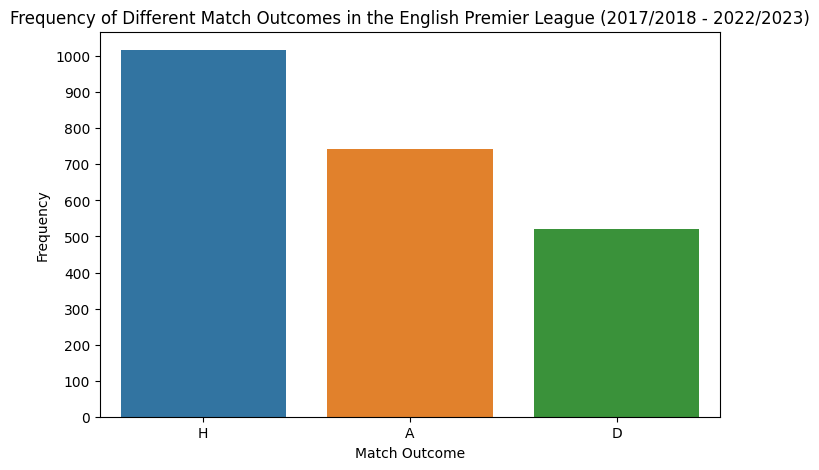

In [14]:
# Compare the frequency of the different results in the English Premier League across all seasons of data
plt.figure(figsize=(8, 5))

# Create our bar plot
bar_plot = sns.barplot(
    x = match_df['FTR'].value_counts().index,
    y = match_df['FTR'].value_counts().values,
    hue = match_df['FTR'].value_counts().index
)

# Change the y ticks so we can see the values better
bar_plot.set_yticks(np.arange(0, 1100, 100))

# Set the title and axis labels
bar_plot.set_title('Frequency of Different Match Outcomes in the English Premier League (2017/2018 - 2022/2023)')
bar_plot.set_xlabel('Match Outcome')
bar_plot.set_ylabel('Frequency')

# Display the plot to the screen
plt.show()

C:\Users\Mathews\AppData\Local\Temp\ipykernel_15004\2742686126.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)


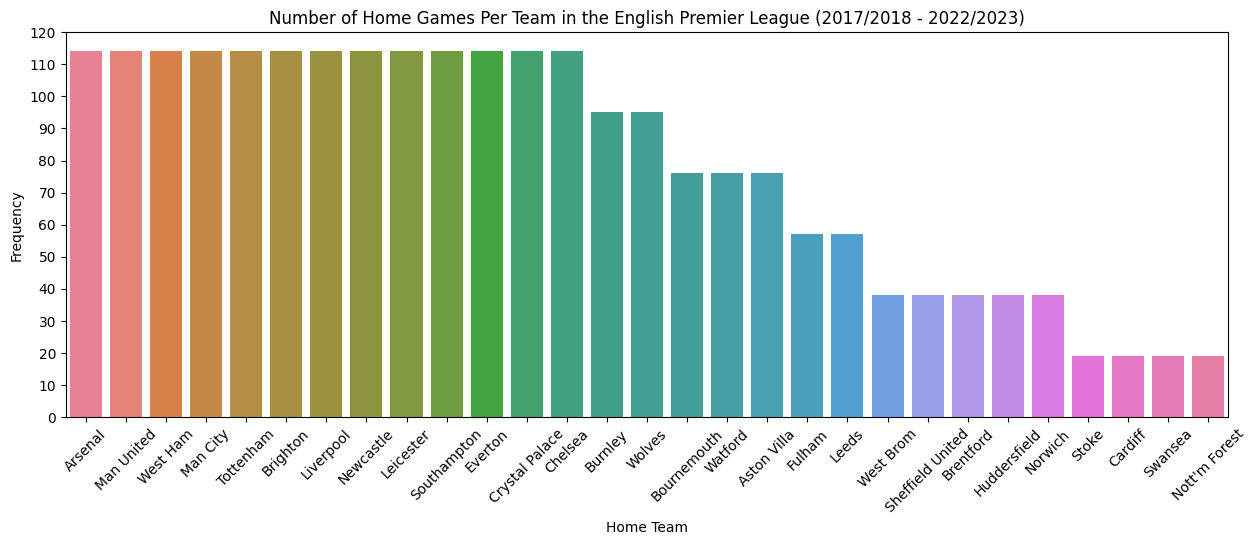

In [15]:
# Find teams with most home games
plt.figure(figsize=(15, 5))
                            
# Create our bar plot
bar_plot = sns.barplot(
    x = match_df['HomeTeam'].value_counts().index,
    y = match_df['HomeTeam'].value_counts().values,
    hue = match_df['HomeTeam'].value_counts().index
)

# Rotate x-axis labels
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)

# Change the y ticks so we can see the values better
bar_plot.set_yticks(np.arange(0, 130, 10))

# Set the title and axis labels
bar_plot.set_title('Number of Home Games Per Team in the English Premier League (2017/2018 - 2022/2023)')
bar_plot.set_xlabel('Home Team')
bar_plot.set_ylabel('Frequency')

# Display the plot to the screen
plt.show()

In [16]:
# Find number of wins, draws and losses for each team

# Create a new data frame with the home team wins, draws and losses
home_team_wins = match_df[match_df['FTR'] == 'H'].groupby('HomeTeam').size().reset_index(name='HomeTeamWins')
home_team_draws = match_df[match_df['FTR'] == 'D'].groupby('HomeTeam').size().reset_index(name='HomeTeamDraws')
home_team_losses = match_df[match_df['FTR'] == 'A'].groupby('HomeTeam').size().reset_index(name='HomeTeamLosses')

# Merge the home team wins, draws and losses data frames
home_team_results = pd.merge(home_team_wins, home_team_draws, how='left', left_on=['HomeTeam'], right_on=['HomeTeam'])
home_team_results = pd.merge(home_team_results, home_team_losses, how='left', left_on=['HomeTeam'], right_on=['HomeTeam'])

# Create a new data frame with the away team wins, draws and losses
away_team_wins = match_df[match_df['FTR'] == 'A'].groupby('AwayTeam').size().reset_index(name='AwayTeamWins')
away_team_draws = match_df[match_df['FTR'] == 'D'].groupby('AwayTeam').size().reset_index(name='AwayTeamDraws')
away_team_losses = match_df[match_df['FTR'] == 'H'].groupby('AwayTeam').size().reset_index(name='AwayTeamLosses')

# Merge the away team wins, draws and losses data frames
away_team_results = pd.merge(away_team_wins, away_team_draws, how='left', left_on=['AwayTeam'], right_on=['AwayTeam'])
away_team_results = pd.merge(away_team_results, away_team_losses, how='left', left_on=['AwayTeam'], right_on=['AwayTeam'])

# Merge the home and away team results data frames
team_results = pd.merge(home_team_results, away_team_results, how='left', left_on=['HomeTeam'], right_on=['AwayTeam'])

# Drop the extra 'AwayTeam' column
team_results = team_results.drop('AwayTeam', axis=1)

# Rename the columns
team_results = team_results.rename(columns={'HomeTeam': 'Team'})

# Merge the home and away results into one column for win, loss and draw
team_results['Wins'] = team_results['HomeTeamWins'] + team_results['AwayTeamWins']
team_results['Draw'] = team_results['HomeTeamDraws'] + team_results['AwayTeamDraws']
team_results['Losses'] = team_results['HomeTeamLosses'] + team_results['AwayTeamLosses']

# Drop the extra columns
team_results = team_results.drop(['HomeTeamWins', 'HomeTeamDraws', 'HomeTeamLosses', 'AwayTeamWins', 'AwayTeamDraws', 'AwayTeamLosses'], axis=1)

# Sort by the total number of wins
team_results = team_results.sort_values(by=['Wins'], ascending=False)

# Show results to screen
team_results.head(50).reset_index(drop=True)

,Team,Wins,Draw,Losses
0,Man City,174,25,29
1,Liverpool,150,49,29
2,Man United,122,54,52
3,Tottenham,120,40,68
4,Arsenal,120,43,65
5,Chelsea,113,54,61
6,Leicester,88,49,91
7,West Ham,81,51,96
8,Newcastle,79,61,88
9,Everton,77,55,96


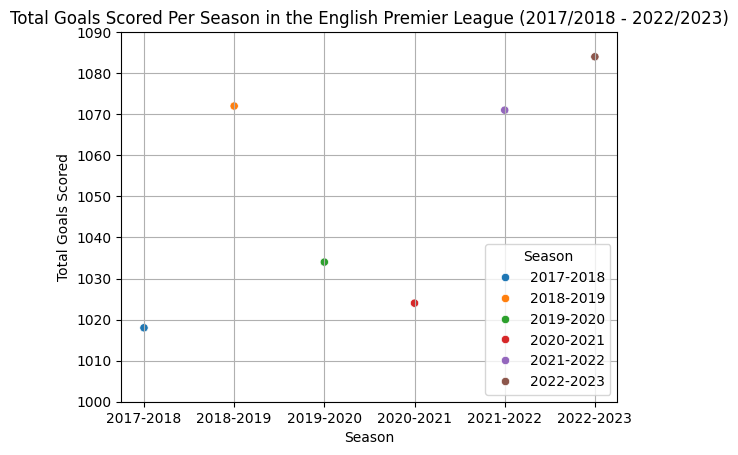

In [17]:
# Find the number of goals scored by season
#TODO CHANGE THIS GRAPH TO A BAR OR LINE GRAPH

# create a new data frame with the just the columns we need
goals_per_season = match_df.loc[:, ['FTHG', 'FTAG', 'Season']].groupby('Season').sum()


scatter_plot = sns.scatterplot(
    x = goals_per_season.index,
    y = goals_per_season['FTHG'] + goals_per_season['FTAG'],
    hue = goals_per_season.index
)

# Set the title and axis labels
scatter_plot.set_title('Total Goals Scored Per Season in the English Premier League (2017/2018 - 2022/2023)')
scatter_plot.set_ylabel('Total Goals Scored')

# Change the y ticks so we can see the values better
scatter_plot.set_yticks(np.arange(1000, 1100, 10))

# Add Grid lines
scatter_plot.grid(True)

# Display the plot to the screen
plt.show()


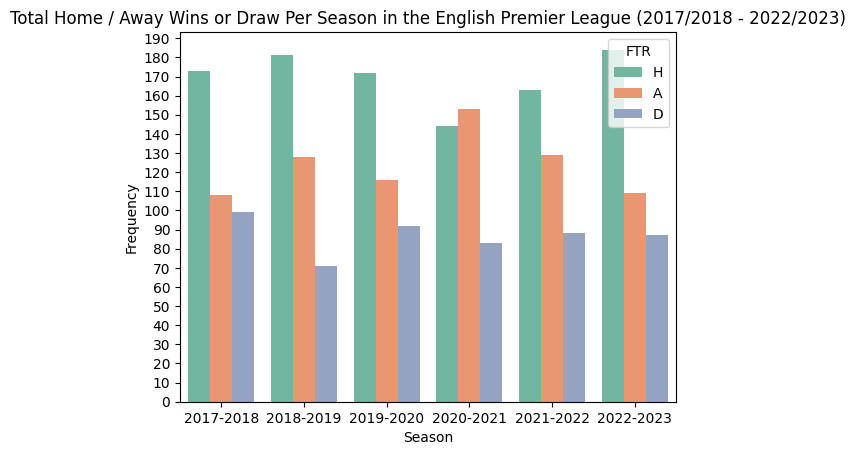

In [18]:
# Find the number of home / away / draw wins by season (as generally home team support will have a positive effect on the home team)

# Create a new data frame with the total home wins and away and draw wins by season
home_away_wins = match_df.loc[:, ['FTR', 'Season']].groupby(['Season'])["FTR"].value_counts().reset_index()
# Create a grouped bar chart
gbar_plot = sns.barplot(
    x = home_away_wins['Season'],
    y = home_away_wins['count'],
    hue = home_away_wins['FTR'],
    palette = "Set2"
)

# Change the y ticks so we can see the values better
gbar_plot.set_yticks(np.arange(0, 200, 10))

# Set the title and axis labels
gbar_plot.set_title('Total Home / Away Wins or Draw Per Season in the English Premier League (2017/2018 - 2022/2023)')
gbar_plot.set_ylabel('Frequency')

# Display the plot to the screen
plt.show()


#### Preprocessing

In [19]:
# Converting match date to day of the week
match_df["matchDate"] = pd.to_datetime(match_df["Date"])
match_df['matchDay'] = match_df['matchDate'].dt.day_name()

# Drop the date columns with little to no relevance to our analysis, as we dont want the models
# to learn by a date level, and should be able to generalize
match_df.drop('Date', axis=1, inplace=True)
match_df.drop('matchDate', axis=1, inplace=True)

print(match_df.shape)

# Convert our text columns to numerical as we cannot use text data in our model using One Hot Encoding
match_df = pd.get_dummies(match_df, columns=['HomeTeam'], prefix = ['HomeTeam'], dtype = int)
match_df = pd.get_dummies(match_df, columns=['AwayTeam'], prefix = ['AwayTeam'], dtype = int)
match_df = pd.get_dummies(match_df, columns=['HTR'], prefix = ['HTR'], dtype = int)
match_df = pd.get_dummies(match_df, columns=['matchDay'], prefix = ['matchDay'], dtype = int)
match_df = pd.get_dummies(match_df, columns=['Season'], prefix = ['Season'], dtype = int)
match_df = pd.get_dummies(match_df, columns=['Referee'], prefix = ['Referee'], dtype = int)

match_df.head()

(2280, 25)


,FTHG,FTAG,FTR,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,home_rating_overall,away_rating_overall,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Bournemouth,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Chelsea,HomeTeam_Crystal Palace,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Nott'm Forest,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Bournemouth,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Chelsea,AwayTeam_Crystal Palace,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Nott'm Forest,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wolves,HTR_A,HTR_D,HTR_H,matchDay_Friday,matchDay_Monday,matchDay_Saturday,matchDay_Sunday,matchDay_Thursday,matchDay_Tuesday,matchDay_Wednesday,Season_2017-2018,Season_2018-2019,Season_2019-2020,Season_2020-2021,Season_2021-2022,Season_2022-2023,Referee_A Madley,Referee_A Marriner,Referee_A Moss,Referee_A Taylor,Referee_C Kavanagh,Referee_C Pawson,Referee_D Bond,Referee_D Coote,Referee_D England,Referee_G Scott,Referee_J Brooks,Referee_J Gillett,Referee_J Moss,Referee_J Smith,Referee_K Friend,Referee_L Mason,Referee_L Probert,Referee_M Atkinson,Referee_M Dean,Referee_M Jones,Referee_M Oliver,Referee_M Salisbury,Referee_N Swarbrick,Referee_O Langford,Referee_P Bankes,Referee_P Tierney,Referee_R East,Referee_R Jones,Referee_R Madley,Referee_S Attwell,Referee_S Hooper,Referee_S Scott,Referee_T Bramall,Referee_T Harrington,Referee_T Robinson
0,4,3,H,2,2,27,6,10,3,9,12,9,4,0,1,0,0,82,78,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,A,0,0,6,14,2,4,6,9,3,10,0,2,0,0,75,84,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,3,A,0,3,19,10,6,5,16,11,8,5,3,3,2,0,83,77,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,3,A,0,2,14,8,4,6,7,19,12,9,1,3,0,0,76,74,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,H,1,0,9,9,4,1,13,10,6,7,1,1,0,0,79,76,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# Create a label encoder object
label_encoder = LabelEncoder()

# Fit the encoder to the dependent variable (target variable)
match_df['FTR'] = label_encoder.fit_transform(match_df['FTR']) 

# Have a look at our data frame
print('Unique values for our label are: ', match_df['FTR'].unique())
print('if the home team wins the label is ', match_df['FTR'][0])
print('if the away team wins the label is ', match_df['FTR'][2])
print('if there is a tie the label is ', match_df['FTR'][5])

label = match_df['FTR']

print('the result for the match in row 149 is ', label[149])

Unique values for our label are:  [2 0 1]
if the home team wins the label is  2
if the away team wins the label is  0
if there is a tie the label is  1
the result for the match in row 149 is  2


Split our dataset into training and testing sets to evaluate our model and prevent data leakage

In [21]:
# Get our target values and flatten the label array
y = np.ravel(match_df['FTR'])

# Assign all columns except the FTR column to the features variable
X = match_df.loc[:, match_df.columns != 'FTR']

# Split our data into training and testing sets
# We set shuffle to false as we want to keep the order of the matches in the data frame so we can use the 
# 2021/2022 and 2022/2023 seasons as our test set use a test size of 0.333 as this will give us 760 test
# samples which is the same as the number of matches in the 2 recent seasons
# https://stats.stackexchange.com/questions/550399/what-is-the-role-of-shuffle-in-train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=0, shuffle=False)

# Confirm the test set has only the the 2 most recent seasons

print(f"Value count of test set:\n {X_test['Season_2022-2023'].value_counts()}\n")
print(f"Value count of test set:\n {X_test['Season_2021-2022'].value_counts()}\n")

# Print out the shape of each set
print("Training and Testing sets sizes (rows,cols):")
print("The shape of X_train is " + str(X_train.shape))
print("The size of y_train is " + str(y_train.shape))
print("The size of X_test set is " + str(X_test.shape))
print("The size of y_test is " + str(y_test.shape))


Value count of test set:
 Season_2022-2023
0    380
1    380
Name: count, dtype: int64

Value count of test set:
 Season_2021-2022
1    380
0    380
Name: count, dtype: int64

Training and Testing sets sizes (rows,cols):
The shape of X_train is (1520, 127)
The size of y_train is (1520,)
The size of X_test set is (760, 127)
The size of y_test is (760,)


Create a separate normalized dataset (Perform feature scaling to normalize our data)

In [22]:
# Normalize the data set as we have a several features with different data scales
# We need to do mix max normalization not standardization, as we have features with different data scales
scaler = MinMaxScaler()                              

# Fit the scaler to the training set and transform the test training set
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

Create a separate PCA dataset (reduce the dimensionality of our dataset)

In [23]:
# Create a PCA object to reduce the number of features to 90% of the variance explained
pca = PCA(n_components=0.90, random_state=0)

# Fit on the train set only
# Use the normalized X train and test set as PCA is sensitive to the scale of the data
pca.fit(X_train_normalized)

# Apply transform to the train/test sets
X_train_PCA = pca.transform(X_train_normalized)
X_test_PCA = pca.transform(X_test_normalized)

# Print the explained variance rate for first 3 components and the total explained variance rate
print("Total Number of Components for 90% variance explained: ", len(pca.explained_variance_ratio_))

print("Explained Variance Ratio for PC1: ", pca.explained_variance_ratio_[0])
print("Explained Variance Ratio for PC2: ", pca.explained_variance_ratio_[1])
print("Explained Variance Ratio for PC3: ", pca.explained_variance_ratio_[2])

Total Number of Components for 90% variance explained:  64
Explained Variance Ratio for PC1:  0.07262001180395358
Explained Variance Ratio for PC2:  0.0691522464085591
Explained Variance Ratio for PC3:  0.06266037433712515


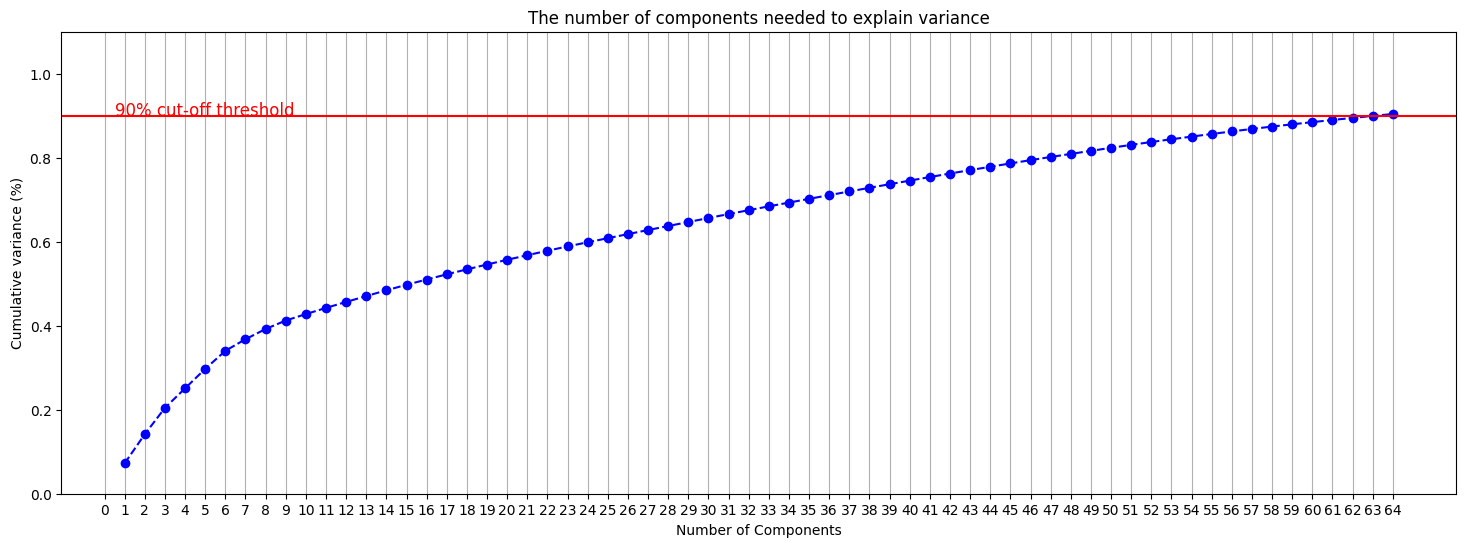

In [24]:
# Create a visual to see the number of components needed to explain variance
plt.rcParams["figure.figsize"] = (18,6)

fig, ax = plt.subplots()
xi = np.arange(1, 65, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 65, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

# Line to show 90% cut-off threshold
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.90, '90% cut-off threshold', color = 'red', fontsize=12)

ax.grid(axis='x')
plt.show()

In [25]:
# Evaluate method that takes in a model, training and testing data and prints
# the cross validation results and the results on the test set
def evaluate_model(model, X_train, X_test, y_train, y_test, kfold, scoring_metrics):
    # Evaluate the model using cross validation for the training set
    results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    
    print("Cross Validation Results on Training Set: ")
    print(f"Accuracy during cross validation: {results['test_accuracy'].mean()}")
    print(f"Balanced Accuracy during cross validation: {results['test_balanced_accuracy'].mean()}")
    print(f"F1 Score during cross validation: {results['test_f1_macro'].mean()}")
    print(f"Precision Score during cross validation: {results['test_precision_macro'].mean()}")
    print(f"Recall Score during cross validation: {results['test_recall_macro'].mean()}\n")

    # Retrain the model and evaluate the same metrics on the test set
    model.fit(X_train, y_train)
    
    # Predict the test set
    y_pred = model.predict(X_test) 
    
    print("Results on Test Set: ")
    print(f"Accuracy on test set : {accuracy_score(y_test, y_pred)}")
    print(f"Balanced Accuracy on test set: {balanced_accuracy_score(y_test, y_pred)}")
    print(f"F1 Score on test set: {f1_score(y_test, y_pred, average='macro')}")
    print(f"Precision Score on test set: {precision_score(y_test, y_pred, average='macro')}")
    print(f"Recall Score on test set: {recall_score(y_test, y_pred, average='macro')}")

In [26]:
# Create SVM model
svm_model = SVC(random_state=0)

# Create KNN model
knn_model = KNeighborsClassifier()

# Create Naive Bayes model
nb_model = GaussianNB()

# Create a dictionary of the models
models = {'KNN':knn_model, 'SVM':svm_model, 'Naive_Bayes':nb_model}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=5)                              

# Define the evaluation metrics we want to use
scoring = ['accuracy', 'balanced_accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

# Train the base models and evaluate them using cross validation
for model_name, model in models.items():
    
    # Evaluate the base model
    print(f"Evaluating the BASE {model_name} <---")
    evaluate_model(model, X_train, X_test, y_train, y_test, skf, scoring)
    
    # Evaluate the base model with normalized data
    print(f"\n\nEvaluating the NORMALIZED {model_name} model <---")
    evaluate_model(model, X_train_normalized, X_test_normalized, y_train, y_test, skf, scoring)
    
    # Evaluate the base model with PCA
    print(f"\n\nEvaluating the PCA {model_name} model <---")
    evaluate_model(model, X_train_PCA, X_test_PCA, y_train, y_test, skf, scoring)
    print("\n")


Evaluating the BASE KNN <---
Cross Validation Results on Training Set: 
Accuracy during cross validation: 0.6263157894736842
Balanced Accuracy during cross validation: 0.5860376693087869
F1 Score during cross validation: 0.579418607431572
Precision Score during cross validation: 0.582074188502076
Recall Score during cross validation: 0.5860376693087869

Results on Test Set: 
Accuracy on test set : 0.6328947368421053
Balanced Accuracy on test set: 0.5912214338184841
F1 Score on test set: 0.5822531574372348
Precision Score on test set: 0.584632735118172
Recall Score on test set: 0.5912214338184841


Evaluating the NORMALIZED KNN model <---
Cross Validation Results on Training Set: 
Accuracy during cross validation: 0.593421052631579
Balanced Accuracy during cross validation: 0.5506317601260451
F1 Score during cross validation: 0.5364537865710554
Precision Score during cross validation: 0.5457611212804478
Recall Score during cross validation: 0.5506317601260451

Results on Test Set: 
Accu

C:\Users\Mathews\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mathews\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mathews\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar

Cross Validation Results on Training Set: 
Accuracy during cross validation: 0.6493421052631578
Balanced Accuracy during cross validation: 0.5523274715531253
F1 Score during cross validation: 0.48709154651728737
Precision Score during cross validation: 0.44134318486070645
Recall Score during cross validation: 0.5523274715531253

Results on Test Set: 
Accuracy on test set : 0.6592105263157895
Balanced Accuracy on test set: 0.5622179707617918
F1 Score on test set: 0.4937864844286104
Precision Score on test set: 0.4424095161197011
Recall Score on test set: 0.5622179707617918


Evaluating the NORMALIZED SVM model <---


C:\Users\Mathews\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Validation Results on Training Set: 
Accuracy during cross validation: 0.6710526315789473
Balanced Accuracy during cross validation: 0.6301899171098161
F1 Score during cross validation: 0.6235682837916758
Precision Score during cross validation: 0.6424626450466276
Recall Score during cross validation: 0.6301899171098161

Results on Test Set: 
Accuracy on test set : 0.7131578947368421
Balanced Accuracy on test set: 0.661717159486273
F1 Score on test set: 0.6612503832089681
Precision Score on test set: 0.6690518220106206
Recall Score on test set: 0.661717159486273


Evaluating the PCA SVM model <---
Cross Validation Results on Training Set: 
Accuracy during cross validation: 0.6282894736842105
Balanced Accuracy during cross validation: 0.5818218421452788
F1 Score during cross validation: 0.5697108482953435
Precision Score during cross validation: 0.5967928170032719
Recall Score during cross validation: 0.5818218421452788

Results on Test Set: 
Accuracy on test set : 0.6513157894736

Create our base models, hyper parameter tuning and model evaluation

In [27]:
# Perform hyper parameter tuning on each model using grid search
# Create a dictionary of hyper parameters for each model we want to tune
svm_parameters = {'kernel':['poly', 'rbf', 'linear'], 'C':[0.1, 1, 10, 100], 'gamma':['scale', 'auto', 0.1, 1, 10], 'degree':list(range(1, 10))}

# For knn neighbor param, we make sure it is odd to prevent ties
knn_parameters = {'n_neighbors':[i for i in range(2, 40) if i % 2 != 0], 'weights':['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'leaf_size':[i for i in range(1, 40)], 'p':[1, 2], 'metric':['minkowski', 'euclidean', 'manhattan', 'chebyshev']}

nb_parameters = {'var_smoothing': np.logspace(0, -10, num=100)}

# Create a dictionary of the parameters
parameters = {'SVM':svm_parameters, 'KNN':knn_parameters, 'Naive_Bayes':nb_parameters}

# Create a dictionary to hold the models after hyper parameter tuning for all 3 data comparisons (base, normalized, normalized + PCA)
best_models = {}
best_models_normalized = {}
best_models_PCA = {}

# Loop through each model and perform hyper parameter tuning
for model_name, model in models.items():
    print(f"\nPerforming hyper parameter tuning on {model_name}...")
    
    # Create a grid search object and fit it to the data to perform hyper parameter tuning
    search = RandomizedSearchCV(estimator=model, param_distributions=parameters[model_name], scoring="accuracy", cv=skf, n_jobs=-1, random_state=0)
    search_results_normalized = RandomizedSearchCV(estimator=model, param_distributions=parameters[model_name], scoring="accuracy", cv=skf, n_jobs=-1, random_state=0)
    search_PCA = RandomizedSearchCV(estimator=model, param_distributions=parameters[model_name], scoring="accuracy", cv=skf, n_jobs=-1, random_state=0)
    
    # Fit the grid search object to the train data for all 3 data comparisons
    search_results = search.fit(X_train, y_train)
    search_results_normalized = search_results_normalized.fit(X_train_normalized, y_train)
    search_results_PCA = search_PCA.fit(X_train_PCA, y_train)
    
    # Get the optimal hyper parameters and corresponding accuracy score
    print(f"Best parameters: {search_results.best_params_}, Best Score: {search_results.best_score_}")
    print(f"Best parameters (Normalized): {search_results_normalized.best_params_}, Best Score: {search_results_normalized.best_score_}")
    print(f"Best parameters (Normalized + PCA): {search_results_PCA.best_params_}, Best Score: {search_results_PCA.best_score_}")
    
    # Find our best models
    best_model = search_results.best_estimator_
    best_model_normalized = search_results_normalized.best_estimator_
    best_model_PCA = search_results_PCA.best_estimator_
    
    # Evaluate the best model using the evaluation method
    # Evaluate the base model
    print(f"\nEvaluating the hyperparameter tuned BASE {model_name} <---")
    evaluate_model(best_model, X_train, X_test, y_train, y_test, skf, scoring)
    
    # Evaluate the base model with normalized data
    print(f"\n\nEvaluating the hyperparameter tuned NORMALIZED {model_name} model <---")
    evaluate_model(best_model_normalized, X_train_normalized, X_test_normalized, y_train, y_test, skf, scoring)
    
    # Evaluate the base model with PCA
    print(f"\n\nEvaluating the hyperparameter tuned PCA {model_name} model <---")
    evaluate_model(best_model_PCA, X_train_PCA, X_test_PCA, y_train, y_test, skf, scoring)
    print("\n")
    
    
    # Save the best models to the dictionary
    best_models[model_name] = best_model
    best_models_normalized[model_name] = best_model_normalized
    best_models_PCA[model_name] = best_model_PCA
    print()




Performing hyper parameter tuning on KNN...
Best parameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 37, 'metric': 'minkowski', 'leaf_size': 38, 'algorithm': 'brute'}, Best Score: 0.7309210526315789
Best parameters (Normalized): {'weights': 'uniform', 'p': 1, 'n_neighbors': 37, 'metric': 'minkowski', 'leaf_size': 38, 'algorithm': 'brute'}, Best Score: 0.6625
Best parameters (Normalized + PCA): {'weights': 'distance', 'p': 1, 'n_neighbors': 23, 'metric': 'minkowski', 'leaf_size': 22, 'algorithm': 'brute'}, Best Score: 0.6256578947368421

Evaluating the hyperparameter tuned BASE KNN <---
Cross Validation Results on Training Set: 
Accuracy during cross validation: 0.7309210526315789
Balanced Accuracy during cross validation: 0.6614770886563023
F1 Score during cross validation: 0.6503345387112567
Precision Score during cross validation: 0.6866694614446195
Recall Score during cross validation: 0.6614770886563023

Results on Test Set: 
Accuracy on test set : 0.7276315789473684
Balance

C:\Users\Mathews\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


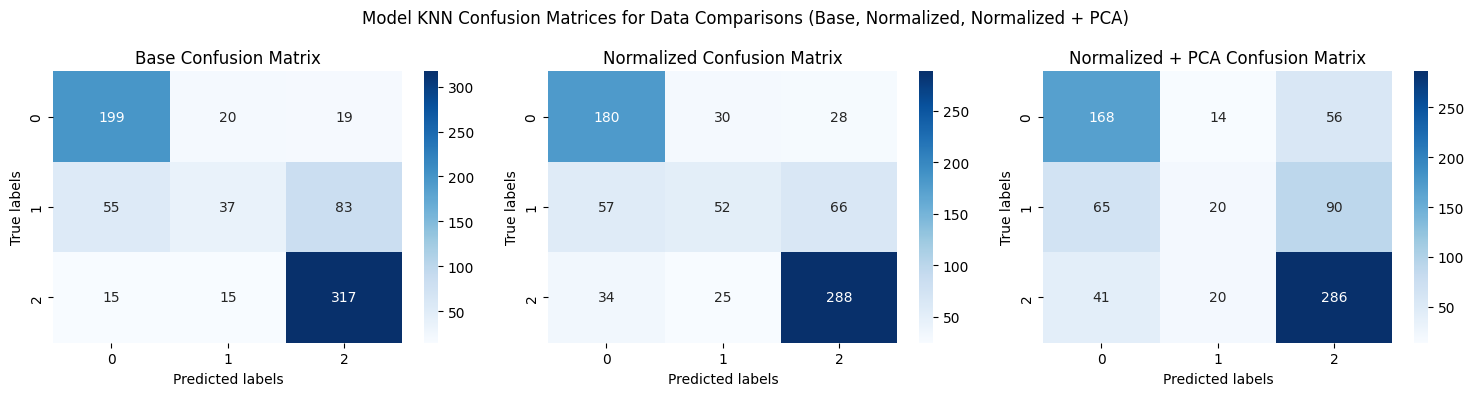

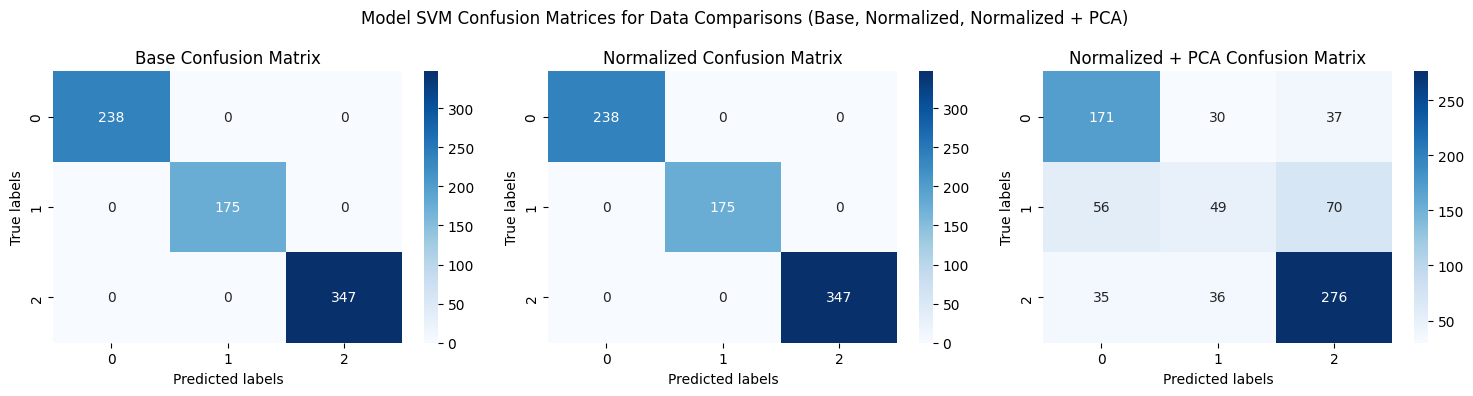

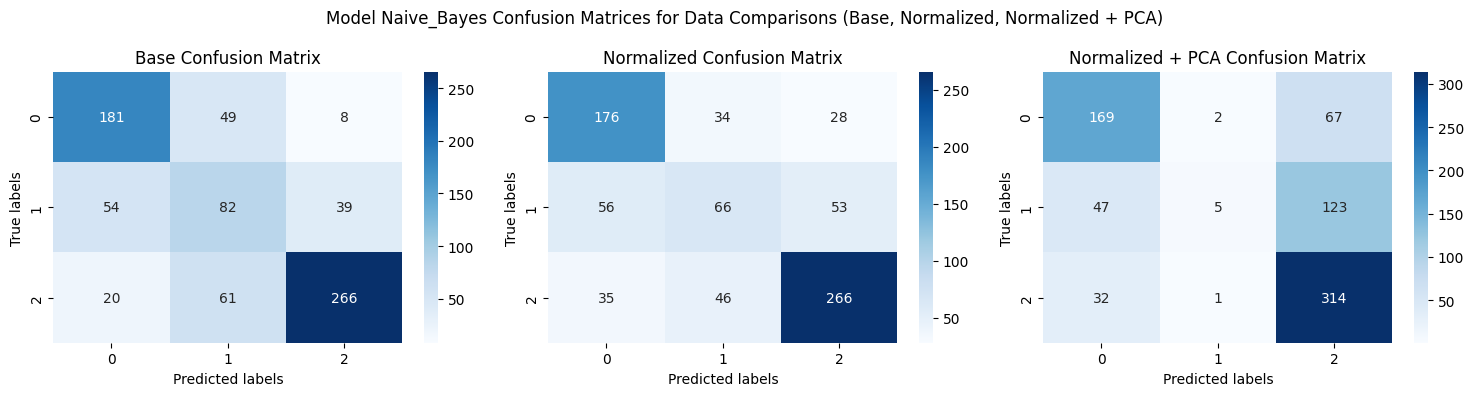

In [28]:
# Define a list of model names and data comparison names
model_names = ['KNN', 'SVM', 'Naive_Bayes']
data_comparison_names = ['Base', 'Normalized', 'Normalized + PCA']

# Get the confusion matrix for each best model and data comparison on the test set
for index in range(len(model_names)):

    # Produce a confusion matrix for the final models 
    conf_matrix_base = confusion_matrix(y_test, best_models[model_names[index]].predict(X_test))
    conf_matrix_normalized = confusion_matrix(y_test, best_models_normalized[model_names[index]].predict(X_test_normalized))
    conf_matrix_PCA = confusion_matrix(y_test, best_models_PCA[model_names[index]].predict(X_test_PCA))
    
    # Create a list of the confusion matrices
    conf_matrices = [conf_matrix_base, conf_matrix_normalized, conf_matrix_PCA]
    
    # Define our figure and axis
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    
    # Loop through each confusion matrix and plot them side by side in 1x3 format
    for i, conf_matrix in enumerate(conf_matrices):
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', ax=axes[i])
        axes[i].set_title(f"{data_comparison_names[i]} Confusion Matrix")
        axes[i].set_xlabel("Predicted labels")
        axes[i].set_ylabel("True labels")

    plt.suptitle(f"Model {model_names[index]} Confusion Matrices for Data Comparisons (Base, Normalized, Normalized + PCA)")
    plt.tight_layout()
    plt.show()

Create our custom neural network models

In [29]:
# one hot-encoding y_train and y_test
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Custom model for base data
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(75, input_dim=127, activation='relu')) 
model.add(tf.keras.layers.Dropout(0.3))                               
model.add(tf.keras.layers.Dense(64, activation='relu'))                 
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.summary()

# Custom model for normalized data
model_normalized = tf.keras.models.Sequential()
model_normalized.add(tf.keras.layers.Dense(75, input_dim=127, activation='relu'))  
model_normalized.add(tf.keras.layers.Dropout(0.3))                               
model_normalized.add(tf.keras.layers.Dense(64, activation='relu'))                 
model_normalized.add(tf.keras.layers.Dropout(0.3))
model_normalized.add(tf.keras.layers.Dense(3, activation='softmax'))
model_normalized.summary()

# Custom model for PCA data
model_PCA = tf.keras.models.Sequential()
model_PCA.add(tf.keras.layers.Dense(75, input_dim=64, activation='relu'))  
model_PCA.add(tf.keras.layers.Dropout(0.3))                               
model_PCA.add(tf.keras.layers.Dense(64, activation='relu'))                 
model_PCA.add(tf.keras.layers.Dropout(0.3))
model_PCA.add(tf.keras.layers.Dense(3, activation='softmax'))
model_PCA.summary()

# Compile the model
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'], optimizer='adam')
model_normalized.compile(loss = 'categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'], optimizer='adam')
model_PCA.compile(loss = 'categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'], optimizer='adam')

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping])
history_normalized = model_normalized.fit(X_train_normalized, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping])
history_PCA = model_PCA.fit(X_train_PCA, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 75)                9600      
                                                                 
 dropout (Dropout)           (None, 75)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4864      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 14659 (57.26 KB)
Trainable params: 14659 (57.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1

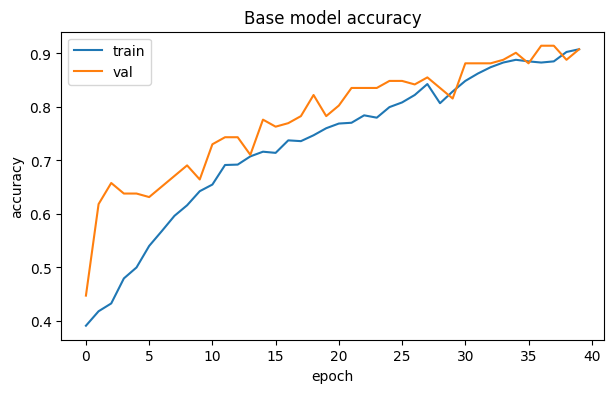

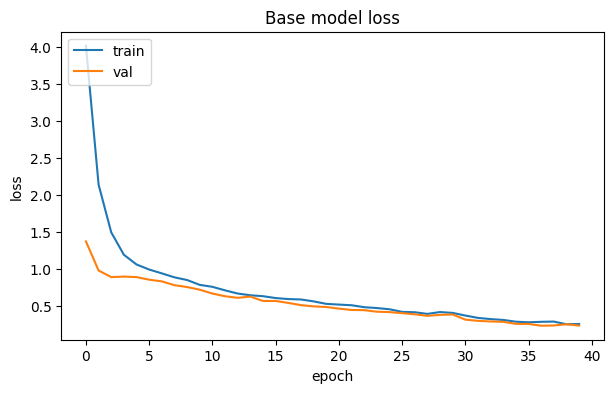

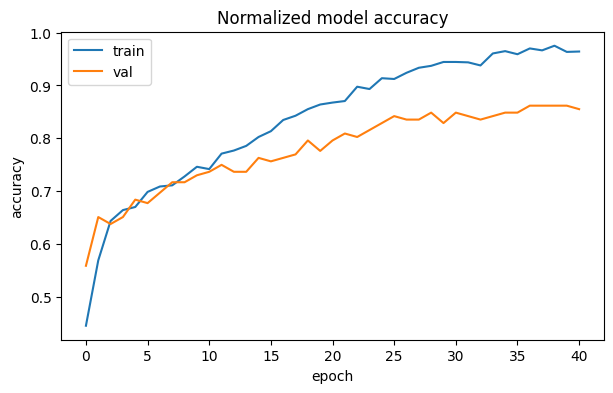

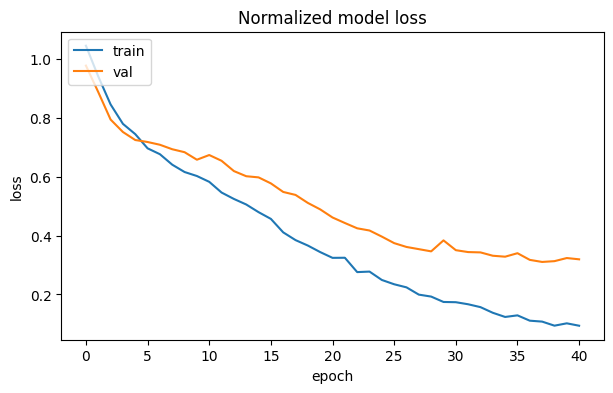

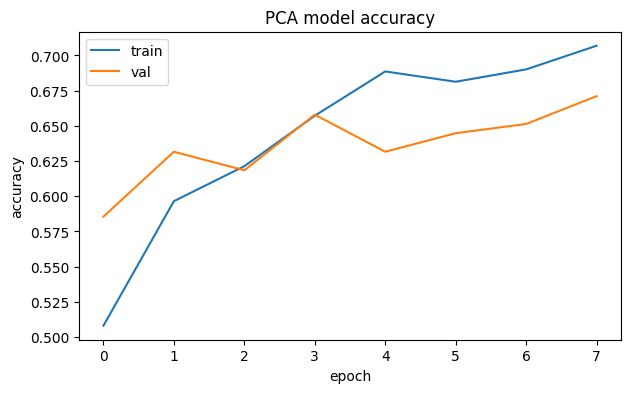

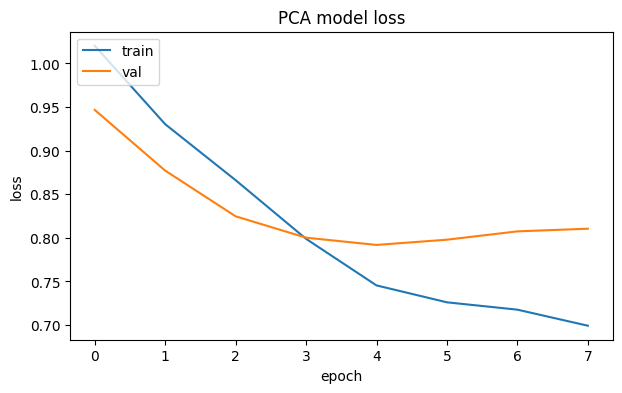

In [46]:
# Function to plot the history data (accuracy and loss)
def plot_history_data(kind, name):
    
    # Set our x, y labels and title
    plt.title(name + ' model ' + kind)
    plt.ylabel(kind)
    plt.xlabel('epoch')
    
    # Add train and validation data legend
    plt.legend(['train', 'val'], loc='upper left')
    
    # Show the plot
    plt.show()

# Plot accuracy history
plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plot_history_data('accuracy', 'Base')

# Plot loss history
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plot_history_data('loss', 'Base')

# Plot accuracy history for normalized data
plt.figure(figsize=(7,4))
plt.plot(history_normalized.history['accuracy'])
plt.plot(history_normalized.history['val_accuracy'])
plot_history_data('accuracy', 'Normalized')

# Plot loss history for normalized data
plt.figure(figsize=(7,4))
plt.plot(history_normalized.history['loss'])
plt.plot(history_normalized.history['val_loss'])
plot_history_data('loss', 'Normalized')

# Plot accuracy history for PCA data
plt.figure(figsize=(7,4))
plt.plot(history_PCA.history['accuracy'])
plt.plot(history_PCA.history['val_accuracy'])
plot_history_data('accuracy', 'PCA')

# Plot loss history for PCA data
plt.figure(figsize=(7,4))
plt.plot(history_PCA.history['loss'])
plt.plot(history_PCA.history['val_loss'])
plot_history_data('loss', 'PCA')



In [31]:
# Evaluate the models on the test data
def evaluate_network(model, X_test, y_test, name, verbose=0):
    # Get the predictions on the test set
    score = model.evaluate(X_test, y_test, verbose=verbose)
    
    # Print the results for each metric
    print(f"Evaluation results for {name} model on test set:")
    print("Test Loss:", score[0])
    print("Test Accuracy:", score[1])
    print("Test Precision:", score[2])
    print("Test Recall:", score[3])
    print("Test F1 Score:", 2 * (score[2] * score[3]) / (score[2] + score[3]))
    print()

# Evaluate the networks for all 3 data comparisons
evaluate_network(model, X_test, y_test, 'Base')
evaluate_network(model_normalized, X_test_normalized, y_test, 'Normalized')
evaluate_network(model_PCA, X_test_PCA, y_test, 'PCA')


Evaluation results for Base model on test set:
Test Loss: 0.20494912564754486
Test Accuracy: 0.932894766330719
Test Precision: 0.9338624477386475
Test Recall: 0.928947389125824
Test F1 Score: 0.9313984341951737

Evaluation results for Normalized model on test set:
Test Loss: 0.2973746955394745
Test Accuracy: 0.8500000238418579
Test Precision: 0.8546666502952576
Test Recall: 0.8434210419654846
Test F1 Score: 0.8490066090349953

Evaluation results for PCA model on test set:
Test Loss: 0.7731767892837524
Test Accuracy: 0.6592105031013489
Test Precision: 0.7458563446998596
Test Recall: 0.5328947305679321
Test F1 Score: 0.6216423564187097



24/24 [==============================] - 0s 544us/step


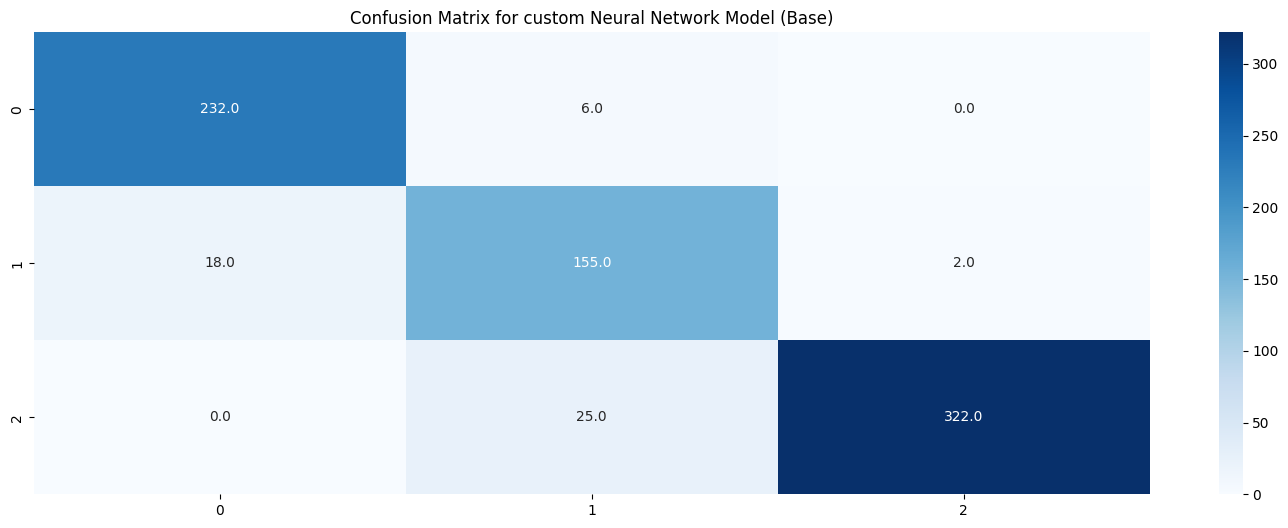

24/24 [==============================] - 0s 522us/step


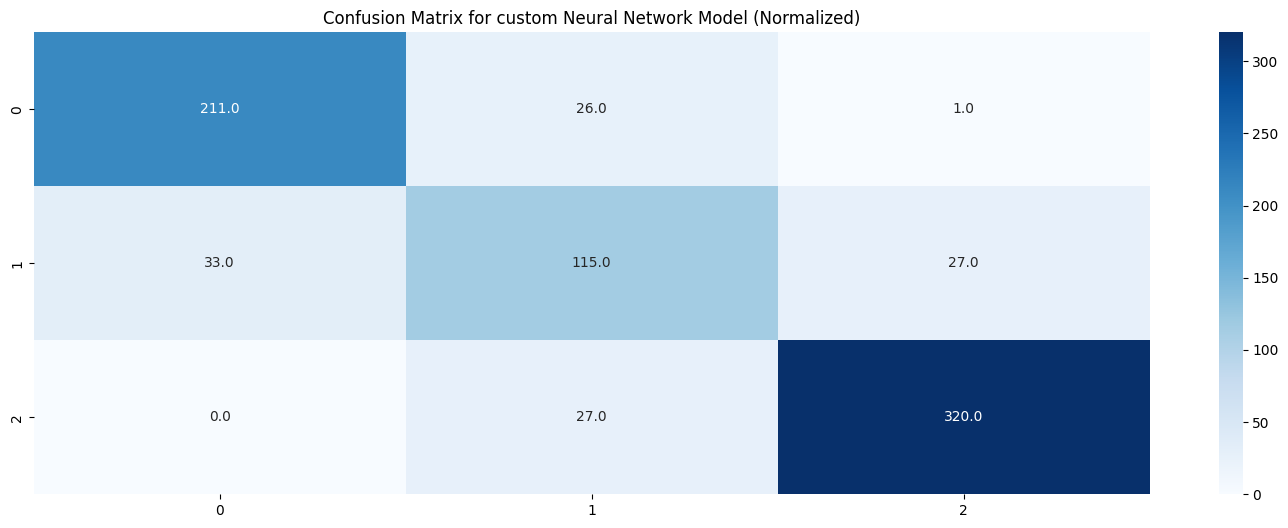

24/24 [==============================] - 0s 528us/step


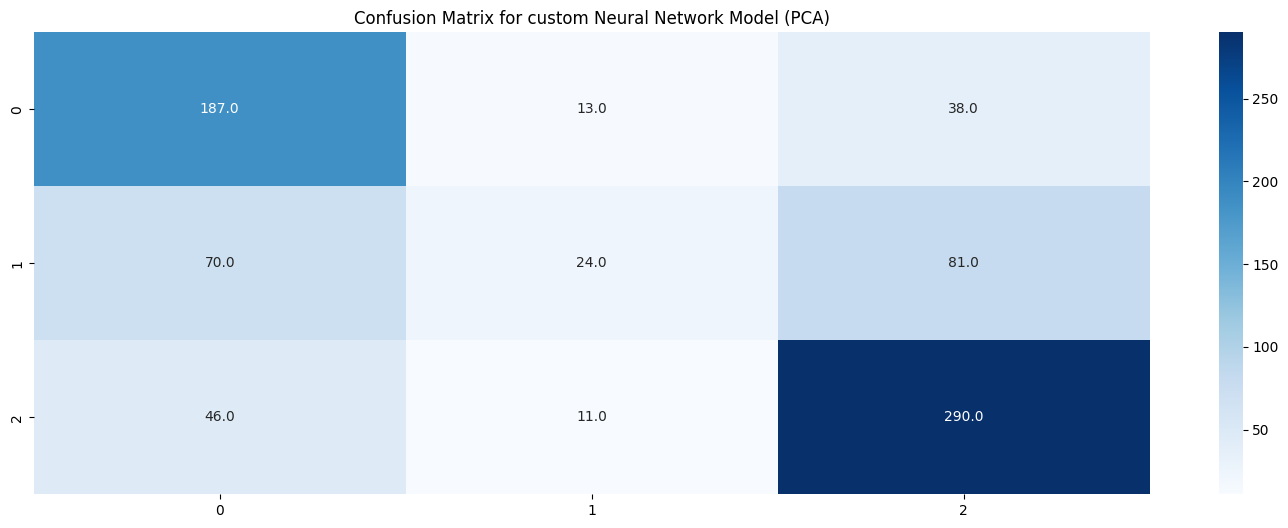

In [32]:
# Function to plot the confusion matrix for the neural network model
def plot_confusion_matrix(name, X_test, y_test, model):
    # Set our x, y labels and title
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for custom Neural Network Model ({name})')
    
    # Produce a confusion matrix for the neural network model
    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
    
    # Plot the confusion matrix
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.1f')

    # Display the plot
    plt.show()

# Plot confusion matrix for the neural network models
plot_confusion_matrix('Base', X_test, y_test, model)
plot_confusion_matrix('Normalized', X_test_normalized, y_test, model_normalized)
plot_confusion_matrix('PCA', X_test_PCA, y_test, model_PCA)